In [42]:
import yfinance as yf
import talib
import numpy as np 
import pandas as pd 
import vectorbt as vbt 
import warnings
from scipy import stats 
import matplotlib.pyplot as plt

In [43]:
#Download stock data from 2018 using yfinance

#Change these variable when needed
TICKER = "BTC-USD" #Ticker symbol (e.g. "QQQ", "SPY", "GLD")
START_DATE = "2018-01-01" #Start date (YYYY-MM-DD) format

#Download data from start date to today
stock_data = yf.download(TICKER, start=START_DATE, interval="1d")

#check if data was downloaded successfully (not empty)
if not stock_data.empty:
    print(f"Successfully downloaded {len(stock_data)} records for {TICKER} from {START_DATE} to today")
    print(f"Data range: {stock_data.index.min().date()} to {stock_data.index.max().date()}")
    print(stock_data.head())
else:
    print(f"Failed to download data for {TICKER} from yfinance")

#Display downloaded data
stock_data

[*********************100%***********************]  1 of 1 completed

Successfully downloaded 2942 records for BTC-USD from 2018-01-01 to today
Data range: 2018-01-01 to 2026-01-20
Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2018-01-01  13657.200195  14112.200195  13154.700195  14112.200195   
2018-01-02  14982.099609  15444.599609  13163.599609  13625.000000   
2018-01-03  15201.000000  15572.799805  14844.500000  14978.200195   
2018-01-04  15599.200195  15739.700195  14522.200195  15270.700195   
2018-01-05  17429.500000  17705.199219  15202.799805  15477.200195   

Price            Volume  
Ticker          BTC-USD  
Date                     
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2018-01-01,13657.200195,14112.200195,13154.700195,14112.200195,10291200000
2018-01-02,14982.099609,15444.599609,13163.599609,13625.000000,16846600192
2018-01-03,15201.000000,15572.799805,14844.500000,14978.200195,16871900160
2018-01-04,15599.200195,15739.700195,14522.200195,15270.700195,21783199744
2018-01-05,17429.500000,17705.199219,15202.799805,15477.200195,23840899072
...,...,...,...,...,...
2026-01-16,95525.117188,95801.890625,94259.273438,95554.101562,33248170537
2026-01-17,95099.921875,95598.476562,95005.617188,95525.156250,16021715122


In [44]:
#Technical analysis indicators using talib

#Make sure stock_data is available from previous cell
if "stock_data" not in locals():
    raise ValueError("stock_data is not defined. Please run the previous cell first.")

#EXTRACT OHLCV data 
# yfinance returns either:
# 1) MultiIndex columns when multiple tickers are downloaded, e.g. ("Close", "QQQ")
# 2) Single-level columns when a single ticker is downloaded, e.g. "Close"
#
# This block handles both cases and extracts OHLCV data
# as NumPy arrays (open_, high, low, close, volume),
# which are required inputs for TA-Lib indicator functions.

if isinstance(stock_data.columns, pd.MultiIndex):
    # MultiIndex case
    open_ = stock_data["Open", TICKER].values
    high = stock_data["High", TICKER].values
    low = stock_data["Low", TICKER].values
    close = stock_data["Close", TICKER].values
    volume = stock_data["Volume", TICKER].values
else:
    # Single-level case
    open_ = stock_data["Open"].values
    high = stock_data["High"].values
    low = stock_data["Low"].values
    close = stock_data["Close"].values
    volume = stock_data["Volume"].values

    print(f"Calculating technical indicators using TA-Lib for {TICKER} from {START_DATE} to today")

#first calculate simple moving averages (SMA)
#defines the trend
sma_20 = talib.SMA(close, timeperiod=20)
sma_50 = talib.SMA(close, timeperiod=50)

#Exponential moving averages (EMA)
#good for signal timing, time the trend
ema_12 = talib.EMA(close, timeperiod=12)
ema_26 = talib.EMA(close, timeperiod=26)

#Moving average convergence divergence (MACD) 
#shows whether momentum is increasing or decreasing by comparing fast and slow trends
macd, macd_signal, macd_hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

#RSI (Relative Strength Index)
#RSI shows whether recent momentum is stretched, not whether price is cheap or expensive
rsi = talib.RSI(close, timeperiod=14)

#Stochastic RSI
#shows how extreme RSI is relative to its recent range, making it a fast timing tool—not a trend indicator
stochrsi_k, stochrsi_d = talib.STOCHRSI(close, timeperiod=14, fastk_period=3, fastd_period=3, fastd_matype=0)

#VWAP (Volume Weighted Average Price)
#the volume-weighted average price up to the current point
#where high-volume trades influence the average more than low-volume trades.
typical_price = (high + low + close) / 3
price_volume = typical_price * volume
cumulative_price_volume = np.cumsum(price_volume)
cumulative_volume = np.cumsum(volume)
vwap = cumulative_price_volume / cumulative_volume

#schaff trend cycle (STC)
#STC turns MACD into a fast, normalized momentum cycle that highlights trend accelerations and slowdowns earlier than MACD alone
cycle_period = 10

# Smooth MACD to reduce noise
macd_cycle = talib.EMA(macd, timeperiod=cycle_period)
macd_smooth = talib.EMA(macd_cycle, timeperiod=cycle_period)

# Find recent high and low of the smoothed MACD
highest_macd = talib.MAX(macd_smooth, timeperiod=cycle_period)
lowest_macd = talib.MIN(macd_smooth, timeperiod=cycle_period)

# Scale MACD into a 0–100 range 
stc_k = 100 * (macd_smooth - lowest_macd) / (highest_macd - lowest_macd) #stochastic k

# Smooth the cycle for cleaner signals
stc_d = talib.EMA(stc_k, timeperiod=3) 

# Unpack Stochastic RSI (returns fastk and fastd)

indicators_df = pd.DataFrame({
    "Date": stock_data.index,
    "Close": close,
    "SMA_20": sma_20,
    "SMA_50": sma_50,
    "EMA_12": ema_12,
    "EMA_26": ema_26,
    "MACD": macd,
    "MACD_Signal": macd_signal,
    "MACD_Hist": macd_hist,
    "RSI": rsi,
    "StochRSI_K": stochrsi_k,
    "StochRSI_D": stochrsi_d,
    "VWAP": vwap,
    "STC_K": stc_k,
    "STC_D": stc_d
})

print("All technical indicators calculated!")
print(f"Data shape: {indicators_df.shape}")
indicators_df.tail(5)

All technical indicators calculated!
Data shape: (2942, 15)


,Date,Close,SMA_20,SMA_50,EMA_12,EMA_26,MACD,MACD_Signal,MACD_Hist,RSI,StochRSI_K,StochRSI_D,VWAP,STC_K,STC_D
2937,2026-01-16,95525.117188,91390.033984,90115.499219,93189.863105,91697.657944,1492.205161,880.312011,611.893150,63.810639,0.0,3.333333e+01,51167.593079,100.0,100.0
2938,2026-01-17,95099.921875,91753.238281,90199.112344,93483.718300,91949.677494,1534.040806,1011.057770,522.983036,61.930822,0.0,-1.894781e-13,51175.533090,100.0,100.0
2939,2026-01-18,93634.429688,92078.052734,90254.765781,93506.904667,92074.473953,1432.430715,1095.332359,337.098356,55.826436,0.0,-1.894781e-13,51185.608560,100.0,100.0
2940,2026-01-19,92553.593750,92284.225781,90297.951406,93360.241449,92109.964308,1250.277141,1126.321315,123.955826,51.773206,0.0,-1.894781e-13,51203.925229,100.0,100.0
2941,2026-01-20,89592.242188,92388.396484,90363.364844,92780.549255,91923.466373,857.082882,1072.473629,-215.390747,42.638785,0.0,-1.894781e-13,51224.634772,100.0,100.0


In [45]:
#prepare price series 
#we need to split the data into training and testing data (in sample and out of sample)
#for robustness our ratio of IS to OOS will be 60/40 or 70/30
#suppress warnings from appearing in the output
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Function to extract the 'Close' price series from a DataFrame
# This function handles different DataFrame column structures (MultiIndex vs single-level)
# Expect stock_data and TICKER already exist from previous cells
def select_close_series(df, ticker):
    """
    Extracts the 'Close' price column from a DataFrame, handling both MultiIndex and single-level columns.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The stock data DataFrame (from yfinance)
    ticker : str
        The ticker symbol (e.g., "BTC-USD", "QQQ")
    
    Returns:
    --------
    pandas.Series
        The Close price series as a float Series
    """
    # Check if DataFrame has MultiIndex columns (happens when downloading multiple tickers)
    if isinstance(df.columns, pd.MultiIndex):
        # Try to select the Close column for the specific ticker
        if ("Close", ticker) in df.columns:
            s = df[("Close", ticker)]
        else:
            # If ticker-specific column not found, search for any column containing 'Close'
            cols = [c for c in df.columns if 'Close' in str(c)]
            if not cols:
                raise KeyError("Close not found")
            s = df[cols[0]]
    else:
        # Single-level columns case - search for any column containing 'Close'
        cols = [c for c in df.columns if 'Close' in str(c)]
        if not cols:
            raise KeyError("Close not found")
        s = df[cols[0]]
    
    # Convert to float and squeeze to ensure it's a 1D Series (remove any extra dimensions)
    return s.astype(float).squeeze()

# Extract the Close price series using our function
# This gives us a clean pandas Series with just the closing prices
close = select_close_series(stock_data, TICKER)

# Rename the series to 'price' for clarity in subsequent analysis
close.name = 'price'

# Simple split: Divide data into training and validation sets
# TRAIN_RATIO determines what percentage of data is used for training
# 0.6 means 60% training, 40% validation
TRAIN_RATIO = 0.6

# Calculate the index where we'll split the data
# int() truncates to ensure we get a valid integer index
split_idx = int(len(close) * TRAIN_RATIO)

# Create training set: all data from the beginning up to split_idx
# .copy() ensures we get an independent copy, not a view
train_close = close.iloc[:split_idx].copy()

# Create validation set: all data from split_idx to the end
# This is our out-of-sample data for testing model performance
val_close = close.iloc[split_idx:].copy()

# Print the date ranges for both datasets to verify the split
# This helps us understand what time periods we're training and validating on
print(f"Data ready: train={train_close.index[0].date()} → {train_close.index[-1].date()} | val={val_close.index[0].date()} → {val_close.index[-1].date()}")

Data ready: train=2018-01-01 → 2022-10-31 | val=2022-11-01 → 2026-01-20


## MACD Crossover Stategy

This section performs a comprehensive grid search optimization for the **Triple EMA Crossover Strategy** using only the **training data**.

MACD Line is calculated by subtracting Slow Length from the Fast Length.

The goal is to find the optimal Fast EMA/Slow EMA/MACD Signal line (EMA) combination that maximizes the Sharpe ratio on OOS data.

**Strategy Logic:** Buy when MACD line crosses above Signal line. Sell when MACD line crosses below signal line.

In [46]:
# Define Parameter Ranges for MACD lines
#Broad Search (High Compute Cost)
MACD_fast_periods   = list(int(p) for p in range(5, 45, 1))
MACD_slow_periods   = list(int(p) for p in range(20, 80, 3))
MACD_signal_periods = list(int(p) for p in range(9, 100, 3))

print("MACD Fast Periods (Momentum):")
for i, period in enumerate(MACD_fast_periods, 1):
    print(f" {i}. {period} periods")

print("\nMACD Slow Periods (Baseline):")
for i, period in enumerate(MACD_slow_periods, 1):
    print(f" {i}. {period} periods")

print("\nMACD Signal Periods (Smoothing/Trigger):")
for i, period in enumerate(MACD_signal_periods, 1):
    print(f" {i}. {period} periods")

# 3. Generate all valid MACD combinations
macd_combinations = []

for fast in MACD_fast_periods:
    for slow in MACD_slow_periods:
        # LOGIC GUARD: Fast must be faster (smaller) than Slow
        if fast < slow:
            for signal in MACD_signal_periods:
                # Note: Signal length does not strictly need to be smaller than 'slow',
                # but valid MACD always requires fast < slow.
                macd_combinations.append((fast, slow, signal))

print(f"Generated {len(macd_combinations)} valid MACD combinations")
print("\nFirst 10 combinations preview:")

# Unpack 'fast, slow, signal' instead of 'ema1, ema2, ema3'
for i, (fast, slow, signal) in enumerate(macd_combinations[:10], 1):
    print(f" {i:2d}. Fast: {fast:2d} | Slow: {slow:2d} | Signal: {signal:2d}")

if len(macd_combinations) > 10:
    print(f" ... and {len(macd_combinations) - 10} more combinations")

print("Ready to test all combinations on training data!")

MACD Fast Periods (Momentum):
 1. 5 periods
 2. 6 periods
 3. 7 periods
 4. 8 periods
 5. 9 periods
 6. 10 periods
 7. 11 periods
 8. 12 periods
 9. 13 periods
 10. 14 periods
 11. 15 periods
 12. 16 periods
 13. 17 periods
 14. 18 periods
 15. 19 periods
 16. 20 periods
 17. 21 periods
 18. 22 periods
 19. 23 periods
 20. 24 periods
 21. 25 periods
 22. 26 periods
 23. 27 periods
 24. 28 periods
 25. 29 periods
 26. 30 periods
 27. 31 periods
 28. 32 periods
 29. 33 periods
 30. 34 periods
 31. 35 periods
 32. 36 periods
 33. 37 periods
 34. 38 periods
 35. 39 periods
 36. 40 periods
 37. 41 periods
 38. 42 periods
 39. 43 periods
 40. 44 periods

MACD Slow Periods (Baseline):
 1. 20 periods
 2. 23 periods
 3. 26 periods
 4. 29 periods
 5. 32 periods
 6. 35 periods
 7. 38 periods
 8. 41 periods
 9. 44 periods
 10. 47 periods
 11. 50 periods
 12. 53 periods
 13. 56 periods
 14. 59 periods
 15. 62 periods
 16. 65 periods
 17. 68 periods
 18. 71 periods
 19. 74 periods
 20. 77 periods

M

In [47]:
# Create MACD Results Collection System

# Create empty list to store all backtest results
MACD_grid_search_results = []

print("MACD Results Collection System Initialized")
# Note: 'macd_combinations' variable must exist from the previous step
print(f" - Will test {len(macd_combinations)} MACD combinations")
print(" - Results will be stored in 'MACD_grid_search_results' list")

# Define what metrics we will collect (All TradingView-style metrics)
metrics_to_collect = [
    # Strategy Parameters (UPDATED for MACD)
    "fast_period",
    "slow_period",
    "signal_period",

    # Return Metrics
    "total_return",         # The total percentage gain or loss over the entire backtest period
    "annualized_return",    # The geometric average return calculated on a yearly basis (CAGR)
    "total_profit",         # The absolute monetary value gained (Net Profit)

    # Risk-Adjusted Return Metrics
    "sharpe_ratio",         # Return divided by volatility. Measures how much return you get per unit of risk
    "sortino_ratio",        # Similar to Sharpe, but only penalizes "bad" (downside) volatility
    "calmar_ratio",         # Annualized Return divided by Maximum Drawdown. Measures return relative to the worst run of trades
    "omega_ratio",          # Probability-weighted ratio of gains versus losses (captures the entire distribution)
    "information_ratio",    # Active return (vs benchmark) divided by tracking error (volatility of active return)
    "tail_ratio",           # Ratio of the 95th percentile of gains to the 95th percentile of losses (measures outliers)
    "deflated_sharpe_ratio",# Adjusts the Sharpe Ratio to account for the probability of finding a good result by luck (multiple testing bias)


    # Risk Metrics
    "max_drawdown",         # The largest percentage drop from a peak to a trough (worst-case scenario).
    "volatility",           # Standard deviation of returns; measures how wildly prices swing.
    "ulcer_index",          # Measures the depth and duration of drawdowns (stress indicator).

    # Trade Performance Metrics
    "win_rate",             # Percentage of trades that were profitable.
    "total_trades",         # The total count of trades executed during the backtest.
    "avg_trade_duration",   # The average amount of time a trade is held open.
    "expectancy",           # The average amount of money you can expect to make (or lose) per trade.
    "profit_factor",        # Gross Profit divided by Gross Loss. (>1 is profitable, >1.5 is good).
    "sqn",                  # System Quality Number; measures the relationship between expectancy and the standard deviation of results.

    # Win/Loss Analysis
    "payoff_ratio",         # Average Win Amount divided by Average Loss Amount.
    "largest_win",          # The single biggest profit from one trade.
    "largest_loss",         # The single biggest loss from one trade.
    "avg_win_amount",       # The average profit of all winning trades.
    "avg_loss_amount",      # The average loss of all losing trades.
    "winning_streak",       # The maximum number of consecutive winning trades.
    "losing_streak",        # The maximum number of consecutive losing trades.

    # Additional Ratios
    "recovery_factor",      # Net Profit divided by Max Drawdown (how fast the strategy recovers from losses).
    "gain_to_pain_ratio",   # Sum of all returns divided by the absolute value of all negative returns.
    "serenity_index"        # A risk-adjusted return metric that penalizes volatility and drawdowns heavily.
]

print("Metrics to collect for each MACD combination:")
for i, metric in enumerate(metrics_to_collect, 1):
    print(f" {i}. {metric.replace('_', ' ').title()}")

print("Ready to start the MACD grid search!")

MACD Results Collection System Initialized
 - Will test 21173 MACD combinations
 - Results will be stored in 'MACD_grid_search_results' list
Metrics to collect for each MACD combination:
 1. Fast Period
 2. Slow Period
 3. Signal Period
 4. Total Return
 5. Annualized Return
 6. Total Profit
 7. Sharpe Ratio
 8. Sortino Ratio
 9. Calmar Ratio
 10. Omega Ratio
 11. Information Ratio
 12. Tail Ratio
 13. Deflated Sharpe Ratio
 14. Max Drawdown
 15. Volatility
 16. Ulcer Index
 17. Win Rate
 18. Total Trades
 19. Avg Trade Duration
 20. Expectancy
 21. Profit Factor
 22. Sqn
 23. Payoff Ratio
 24. Largest Win
 25. Largest Loss
 26. Avg Win Amount
 27. Avg Loss Amount
 28. Winning Streak
 29. Losing Streak
 30. Recovery Factor
 31. Gain To Pain Ratio
 32. Serenity Index
Ready to start the MACD grid search!


In [48]:
import numpy as np
import pandas as pd
import vectorbt as vbt

# --- SETUP & INITIALIZATION ---
print("INITIATING MACD CROSSOVER GRID SEARCH OPTIMIZATION")
print("=" * 70)
print(f"Testing Strategy: MACD Trend Following (Fast/Slow/Signal)")
print(f"Training Period: {train_close.index[0].date()} -> {train_close.index[-1].date()}")
print(f"Initial Capital: $100,000")
print(f"Transaction Costs: 0.05% per trade (fees + slippage)")
print(f"Optimization Metric: Sharpe Ratio (risk-adjusted returns)")
print("=" * 70)

# Ensure results container exists
if 'MACD_grid_search_results' not in locals():
    MACD_grid_search_results = []

total_combinations = len(macd_combinations)
successful_tests = 0
failed_tests = 0
skipped_tests = 0

print(f"Starting grid search across {total_combinations} MACD parameter combos... \n")

# --- MAIN ITERATION LOOP ---
for i, (fast_period, slow_period, signal_period) in enumerate(macd_combinations, 1):
    
    # Initialize iteration-specific variables to ensure scope safety
    sharpe_ratio = np.nan
    total_return = np.nan
    
    try:
        # 1. INDICATORS
        macd_ind = vbt.MACD.run(
            train_close, 
            fast_window=fast_period, 
            slow_window=slow_period, 
            signal_window=signal_period
        )

        # 2. SIGNALS (Entry/Exit)
        entries_raw = macd_ind.macd_crossed_above(macd_ind.signal)
        exits_raw = macd_ind.macd_crossed_below(macd_ind.signal)

        # 3. CLEANING (Ensure 1D Series)
        entries = pd.Series(np.asarray(entries_raw).ravel(), index=train_close.index, dtype=bool)
        exits   = pd.Series(np.asarray(exits_raw).ravel(),   index=train_close.index, dtype=bool)

        # 4. BACKTEST SIMULATION
        portfolio = vbt.Portfolio.from_signals(
            close=train_close,
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.0005,      # 0.05%
            slippage=0.0005,  # 0.05%
            freq="D"
        )

        # 5. METRICS CALCULATION
        total_trades = int(len(portfolio.trades))
        
        # --- FREQUENCY CHECK (Soft Skip) ---
        # Calculate years to determine trade frequency
        years = max((train_close.index[-1] - train_close.index[0]).days / 365.25, 1e-9)
        trades_per_year = total_trades / years

        if trades_per_year < 2:
            skipped_tests += 1
            # We skip the rest of the loop for this iteration, but don't count it as a failure
            continue

        # Standard Metrics
        total_return = float(portfolio.total_return())
        annualized_return = float(portfolio.annualized_return(freq='D'))
        max_drawdown = float(portfolio.max_drawdown())
        volatility = float(portfolio.annualized_volatility(freq='D'))
        sharpe_ratio = float(portfolio.sharpe_ratio(freq='D'))
        sortino_ratio = float(portfolio.sortino_ratio(freq='D'))

        # Advanced Metrics (Safe Handling)
        try:
            information_ratio = float(portfolio.information_ratio(freq='D'))
        except: information_ratio = np.nan

        try:
            tail_ratio = float(portfolio.tail_ratio(freq='D'))
        except: tail_ratio = np.nan

        try:
            deflated_sharpe_ratio = float(portfolio.deflated_sharpe_ratio(freq='D'))
        except: deflated_sharpe_ratio = np.nan

        # Ulcer Index
        try:
            returns_series = portfolio.returns()
            cum = (1 + returns_series).cumprod()
            peak = cum.cummax()
            dd = (cum - peak) / peak
            ulcer_index = float(np.sqrt((dd.pow(2)).mean()))
        except: ulcer_index = np.nan

        # Trade Stats
        trades = portfolio.trades
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0
        avg_win = 0.0
        avg_loss = 0.0

        if total_trades > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                
                win_rate_pct = (len(pos) / len(tr)) * 100.0
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                profit_factor = (gains / losses) if losses > 0 else np.inf
                expectancy = float(tr.mean())
                avg_win = float(pos.mean()) if len(pos) else 0.0
                avg_loss = float(abs(neg.mean())) if len(neg) else 0.0

        payoff_ratio = (avg_win / avg_loss) if avg_loss > 0 else np.inf
        
        try:
            winning_streak = int(trades.winning_streak())
            losing_streak = int(trades.losing_streak())
        except:
            winning_streak, losing_streak = np.nan, np.nan

        # 6. STORE RESULTS
        MACD_grid_search_results.append({
            "Fast_Period": fast_period,
            "Slow_Period": slow_period,
            "Signal_Period": signal_period,
            "Total_Return": total_return,
            "Annualized_Return": annualized_return,
            "Max_Drawdown": max_drawdown,
            "Volatility": volatility,
            "Sharpe_Ratio": sharpe_ratio,
            "Sortino_Ratio": sortino_ratio,
            "Information_Ratio": information_ratio,
            "Tail_Ratio": tail_ratio,
            "Deflated_Sharpe": deflated_sharpe_ratio,
            "Ulcer_Index": ulcer_index,
            "Total_Trades": total_trades,
            "Win_Rate": win_rate_pct,
            "Profit_Factor": profit_factor,
            "Expectancy": expectancy,
            "Avg_Win_Amount": avg_win,
            "Avg_Loss_Amount": avg_loss,
            "Payoff_Ratio": payoff_ratio,
            "Winning_Streak": winning_streak,
            "Losing_Streak": losing_streak,
            "Trades_Per_Year": trades_per_year
        })

        successful_tests += 1

    except Exception as e:
        failed_tests += 1
        # Optional: Print error only for specific debugging, otherwise keep console clean
        # print(f"Error ({fast_period}/{slow_period}/{signal_period}): {e}")
        continue

    # --- PROGRESS UPDATES (Outside Try/Except) ---
    if i % 10 == 0 or i == total_combinations:
        progress_pct = (i / total_combinations) * 100
        print(f"Progress: {i}/{total_combinations} ({progress_pct:.1f}%)")
        print(f"Success: {successful_tests} | Skipped: {skipped_tests} | Failed: {failed_tests}")
        
        # Only print details if the last iteration was actually successful
        if not np.isnan(sharpe_ratio):
             print(f"    Latest: MACD({fast_period},{slow_period},{signal_period}) -> Sharpe: {sharpe_ratio:.2f}, Return: {total_return:.1%}\n")
        else:
             print(f"    Latest: MACD({fast_period},{slow_period},{signal_period}) -> (Skipped/Failed)\n")

# --- FINAL SUMMARY ---
print("\n" + "=" * 70)
print("GRID SEARCH COMPLETED!")
print("=" * 70)
print(f"Total combinations attempted: {total_combinations}")
print(f"Successfully stored: {successful_tests}")
print(f"Skipped (Low Freq): {skipped_tests}")
print(f"Failed (Errors): {failed_tests}")

if total_combinations > 0:
    success_rate = (successful_tests / total_combinations) * 100
    print(f"Usable Data Rate: {success_rate:.1f}%")

print("\nResults stored in 'MACD_grid_search_results'")

INITIATING MACD CROSSOVER GRID SEARCH OPTIMIZATION
Testing Strategy: MACD Trend Following (Fast/Slow/Signal)
Training Period: 2018-01-01 -> 2022-10-31
Initial Capital: $100,000
Transaction Costs: 0.05% per trade (fees + slippage)
Optimization Metric: Sharpe Ratio (risk-adjusted returns)
Starting grid search across 21173 MACD parameter combos... 

Progress: 10/21173 (0.0%)
Success: 10 | Skipped: 0 | Failed: 0
    Latest: MACD(5,20,36) -> Sharpe: 1.00, Return: 506.1%

Progress: 20/21173 (0.1%)
Success: 20 | Skipped: 0 | Failed: 0
    Latest: MACD(5,20,66) -> Sharpe: 0.83, Return: 307.7%

Progress: 30/21173 (0.1%)
Success: 30 | Skipped: 0 | Failed: 0
    Latest: MACD(5,20,96) -> Sharpe: 0.83, Return: 289.7%

Progress: 40/21173 (0.2%)
Success: 40 | Skipped: 0 | Failed: 0
    Latest: MACD(5,23,33) -> Sharpe: 0.92, Return: 398.1%

Progress: 50/21173 (0.2%)
Success: 50 | Skipped: 0 | Failed: 0
    Latest: MACD(5,23,63) -> Sharpe: 1.03, Return: 559.3%

Progress: 60/21173 (0.3%)
Success: 60 | S

In [49]:
import pandas as pd

# --- ANALYZE MACD GRID SEARCH RESULTS ---

# 1. Convert the list of results (dictionaries) into a Pandas DataFrame.
results_df = pd.DataFrame(MACD_grid_search_results)

# Quick check to ensure we have data
if results_df.empty:
    print("No results to analyze. Please check if the grid search ran successfully.")
else:
    print("MACD Grid Search Results Analysis")
    print("=" * 50)
    print(f"Total combinations tested: {len(results_df)}")
    print(f"Results shape: {results_df.shape}")
    print(results_df.head())

    # --- COMPREHENSIVE STATISTICS ---
    print("\nComprehensive Performance Statistics:")
    print("-" * 50)

    # Return Metrics
    print("Return Metrics:")
    print(f"   Best Total Return: {results_df['Total_Return'].max():.2%}")
    print(f"   Average Total Return: {results_df['Total_Return'].mean():.2%}")
    print(f"   Best Annualized Return: {results_df['Annualized_Return'].max():.2%}")

    # Risk-Adjusted Metrics
    print("\nRisk-Adjusted Metrics:")
    print(f"   Best Sharpe Ratio: {results_df['Sharpe_Ratio'].max():.3f}")
    print(f"   Best Sortino Ratio: {results_df['Sortino_Ratio'].max():.3f}")

    # --- RISK METRICS ---
    print("Risk Metrics:")
    
    # Note: VBT Drawdowns are typically negative float values (e.g., -0.20 for 20% down).
    # Therefore, .min() is the largest negative number (Deepest Crash).
    # .max() is the smallest negative number (Safest/Smallest Drawdown).
    
    print(f"   Average Max Drawdown: {results_df['Max_Drawdown'].mean():.2%}")
    print(f"   Deepest (Worst) Drawdown: {results_df['Max_Drawdown'].min():.2%}") 
    print(f"   Smallest (Best) Drawdown: {results_df['Max_Drawdown'].max():.2%}") 
    print(f"   Average Volatility: {results_df['Volatility'].mean():.2%}")

    # --- TRADE PERFORMANCE ---
    print("Trade Performance:")
    print(f"   Best Win Rate: {results_df['Win_Rate'].max():.1f}%") 
    print(f"   Average Win Rate: {results_df['Win_Rate'].mean():.1f}%")
    print(f"   Best Profit Factor: {results_df['Profit_Factor'].max():.2f}")
    print(f"   Total Trades Range: {results_df['Total_Trades'].min():.0f} - {results_df['Total_Trades'].max():.0f}")

    # --- ADDITIONAL METRICS ---
    print("Additional Metrics:")
    print(f"   Best Expectancy: {results_df['Expectancy'].max():.4f}")
    print(f"   Average Trades per Year: {results_df['Trades_Per_Year'].mean():.1f}")
    print(f"   Best Ulcer Index (Lower is better): {results_df['Ulcer_Index'].min():.3f}")

    # --- FIND THE WINNER ---
    # Find the row index with the highest Sharpe Ratio
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]

    print("\n" + "="*50)
    print("BEST STRATEGY (by Sharpe Ratio)")
    print("=" * 50)
    print(f"Fast Period:   {int(best_result['Fast_Period'])}")
    print(f"Slow Period:   {int(best_result['Slow_Period'])}")
    print(f"Signal Period: {int(best_result['Signal_Period'])}")
    print("-" * 20)
    print(f"Total Return:  {best_result['Total_Return']:.2%}")
    print(f"Sharpe Ratio:  {best_result['Sharpe_Ratio']:.3f}")
    print(f"Sortino Ratio: {best_result['Sortino_Ratio']:.3f}")
    print(f"Max Drawdown:  {best_result['Max_Drawdown']:.2%}")
    print(f"Win Rate:      {best_result['Win_Rate']:.1f}%") 
    print(f"Total Trades:  {int(best_result['Total_Trades'])}")

    print("\nTop 5 Best Performers (by Sharpe):")
    print("-" * 50)
    
    # Get top 5 rows sorted by Sharpe Ratio
    top_5 = results_df.nlargest(5, "Sharpe_Ratio")

    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        print(f"{i}. MACD({int(row['Fast_Period'])}, {int(row['Slow_Period'])}, {int(row['Signal_Period'])}) "
              f"-> Sharpe: {row['Sharpe_Ratio']:.3f} | Return: {row['Total_Return']:.1%} | DD: {row['Max_Drawdown']:.1%}")

    print("\nAnalysis complete! Best MACD parameters identified.")

MACD Grid Search Results Analysis
Total combinations tested: 21173
Results shape: (21173, 23)
   Fast_Period  Slow_Period  Signal_Period  Total_Return  Annualized_Return  \
0            5           20              9      3.638879           0.373452   
1            5           20             12      2.288892           0.279161   
2            5           20             15      3.628854           0.372838   
3            5           20             18      3.267492           0.349954   
4            5           20             21      2.668755           0.308404   

   Max_Drawdown  Volatility  Sharpe_Ratio  Sortino_Ratio  Information_Ratio  \
0     -0.457062    0.497864      0.883880       1.383764           0.007529   
1     -0.574733    0.496905      0.741742       1.142386           0.000679   
2     -0.612169    0.497548      0.883178       1.384520           0.007465   
3     -0.622092    0.499522      0.847928       1.327427           0.005965   
4     -0.699836    0.510460      0.7

In [50]:
import vectorbt as vbt
import numpy as np
import pandas as pd

# --- COMPARE WITH BENCHMARK: BEST MACD vs. BUY & HOLD ---

if results_df.empty:
    print("No results to compare to benchmark")
else:
    # 1. RETRIEVE BEST STRATEGY PARAMETERS
    # Use the column names from your analysis block: 'Sharpe_Ratio', 'Fast_Period', etc.
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]
    
    # Extract parameters (casting to int for safety)
    fast_window = int(best_result['Fast_Period'])
    slow_window = int(best_result['Slow_Period'])
    signal_window = int(best_result['Signal_Period'])

    print(f"BENCHMARK ANALYSIS: Best MACD({fast_window}, {slow_window}, {signal_window})")

    # --- 2. RECREATE BEST STRATEGY ---
    
    # Run MACD Indicator with the winning parameters
    macd_ind = vbt.MACD.run(
        train_close, 
        fast_window=fast_window, 
        slow_window=slow_window, 
        signal_window=signal_window
    )

    # Generate Signals
    entries = macd_ind.macd_crossed_above(macd_ind.signal)
    exits = macd_ind.macd_crossed_below(macd_ind.signal)

    # Run the Portfolio for the Best Strategy
    best_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.0005,      # 0.05% trading fee
        freq='D'
    )

    # --- 3. CREATE BUY & HOLD BENCHMARK ---
    
    # Create an array of "False" for every single day
    benchmark_entries = np.zeros(len(train_close), dtype=bool)
    # Set the VERY FIRST day to "True" (Buy once at the start)
    benchmark_entries[0] = True
    # Create an array of "False" for exits (Never sell)
    benchmark_exits = np.zeros(len(train_close), dtype=bool)

    # Run the Portfolio for the Benchmark
    benchmark_pf = vbt.Portfolio.from_signals(
        close=train_close,
        entries=benchmark_entries,
        exits=benchmark_exits,
        init_cash=100_000,
        fees=0.0005,
        freq='D'
    )

    # --- 4. CALCULATE METRICS ---
    
    # Benchmark Metrics (calculated fresh here to be safe)
    bench_return = benchmark_pf.total_return()
    bench_annualized = benchmark_pf.annualized_return(freq='D')
    bench_sharpe = benchmark_pf.sharpe_ratio(freq='D')
    bench_sortino = benchmark_pf.sortino_ratio(freq='D')
    bench_dd = benchmark_pf.max_drawdown()
    bench_volatility = benchmark_pf.annualized_volatility(freq='D')

    # Market Beta (Strategy Volatility / Market Volatility)
    # using 'Volatility' from your results_df
    market_beta = best_result['Volatility'] / bench_volatility if bench_volatility != 0 else np.nan

    # --- 5. PRINT PERFORMANCE COMPARISON ---
    print("\nPERFORMANCE COMPARISON:")

    # Print Strategy Stats (using data from results_df)
    print(f"Strategy (MACD {fast_window}, {slow_window}, {signal_window}):")
    print(f"   Total Return:       {best_result['Total_Return']:.2%}")
    print(f"   Annualized Return:  {best_result['Annualized_Return']:.2%}")
    print(f"   Sharpe Ratio:       {best_result['Sharpe_Ratio']:.3f}")
    print(f"   Sortino Ratio:      {best_result['Sortino_Ratio']:.3f}")
    print(f"   Max Drawdown:       {best_result['Max_Drawdown']:.2%}")
    print(f"   Volatility:         {best_result['Volatility']:.2%}")
    print(f"   Total Trades:       {int(best_result['Total_Trades'])}")
    print(f"   Win Rate:           {best_result['Win_Rate']:.1f}%")
    print(f"   Profit Factor:      {best_result['Profit_Factor']:.2f}")

    # Print Benchmark Stats
    print(f"Benchmark (Buy & Hold):")
    print(f"   Total Return:       {bench_return:.2%}")
    print(f"   Annualized Return:  {bench_annualized:.2%}")
    print(f"   Sharpe Ratio:       {bench_sharpe:.3f}")
    print(f"   Sortino Ratio:      {bench_sortino:.3f}")
    print(f"   Max Drawdown:       {bench_dd:.2%}")
    print(f"   Volatility:         {bench_volatility:.2%}")

    # --- 6. OUTPERFORMANCE METRICS ---
    excess_return = best_result['Total_Return'] - bench_return
    excess_annualized = best_result['Annualized_Return'] - bench_annualized
    sharpe_diff = best_result['Sharpe_Ratio'] - bench_sharpe
    sortino_diff = best_result['Sortino_Ratio'] - bench_sortino
    
    # Drawdown comparison:
    # If strategy is -0.30 and benchmark is -0.80 -> -0.30 - (-0.80) = +0.50 (Better)
    excess_dd = best_result['Max_Drawdown'] - bench_dd

    print(f"OUTPERFORMANCE METRICS:")
    print(f"   Excess Return:              {excess_return:.2%}")
    print(f"   Excess Annualized Return:   {excess_annualized:.2%}")
    print(f"   Sharpe Difference:          {sharpe_diff:.3f}")
    print(f"   Sortino Difference:         {sortino_diff:.3f}")
    
    dd_label = 'Better' if excess_dd > 0 else 'X Worse'
    print(f"   Excess Max Drawdown:        {excess_dd:.2%} ({dd_label})")

    beta_label = 'Lower risk' if market_beta < 1 else '! Higher risk'
    print(f"   Market Beta (approx):       {market_beta:.3f} ({beta_label})")

BENCHMARK ANALYSIS: Best MACD(43, 77, 18)

PERFORMANCE COMPARISON:
Strategy (MACD 43, 77, 18):
   Total Return:       1740.26%
   Annualized Return:  82.63%
   Sharpe Ratio:       1.523
   Sortino Ratio:      2.514
   Max Drawdown:       -30.87%
   Volatility:         46.59%
   Total Trades:       18
   Win Rate:           61.1%
   Profit Factor:      9.49
Benchmark (Buy & Hold):
   Total Return:       50.00%
   Annualized Return:  8.75%
   Sharpe Ratio:       0.489
   Sortino Ratio:      0.696
   Max Drawdown:       -81.53%
   Volatility:         73.87%
OUTPERFORMANCE METRICS:
   Excess Return:              1690.26%
   Excess Annualized Return:   73.89%
   Sharpe Difference:          1.034
   Sortino Difference:         1.818
   Excess Max Drawdown:        50.67% (Better)
   Market Beta (approx):       0.631 (Lower risk)


In [51]:
import vectorbt as vbt
import numpy as np
import pandas as pd

# --- VALIDATE BEST MACD COMBO: IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON ---

# Set frequency default if not already set
if 'FREQ' not in globals():
    FREQ = "1D"

if results_df.empty:
    print("No results to validate.")
else:
    # 1. RETRIEVE THE CHAMPION
    # We grab the row with the highest Sharpe Ratio
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]
    
    # Extract MACD parameters (ensure they are integers)
    fast_window = int(best_result['Fast_Period'])
    slow_window = int(best_result['Slow_Period'])
    signal_window = int(best_result['Signal_Period'])

    # 2. CALCULATE INDICATORS ON NEW DATA (Validation Set)
    # Important: Use 'val_close' here (Unseen Data)
    macd_val = vbt.MACD.run(
        val_close, 
        fast_window=fast_window, 
        slow_window=slow_window, 
        signal_window=signal_window
    )

    # 3. GENERATE SIGNALS
    # Standard MACD Logic:
    # Buy when MACD Line crosses ABOVE Signal Line
    entries_val = macd_val.macd_crossed_above(macd_val.signal)
    
    # Sell when MACD Line crosses BELOW Signal Line
    exits_val = macd_val.macd_crossed_below(macd_val.signal)

    # 4. RUN THE VALIDATION PORTFOLIO
    pf_val = vbt.Portfolio.from_signals(
        close=val_close,
        entries=entries_val,
        exits=exits_val,
        init_cash=100_000,
        fees=0.0005,      # 0.05% Fees
        slippage=0.0005,  # 0.05% Slippage
        freq=FREQ
    )
    
    # --- OUT-OF-SAMPLE METRICS ---
    
    # 1. Return & Risk Metrics
    val_total_return = pf_val.total_return()
    val_annualized_return = pf_val.annualized_return(freq=FREQ)
    val_sharpe = pf_val.sharpe_ratio(freq=FREQ)
    val_sortino = pf_val.sortino_ratio(freq=FREQ)
    val_max_drawdown = pf_val.max_drawdown()
    val_volatility = pf_val.annualized_volatility(freq=FREQ)

    # 2. Trade Frequency Metrics
    trades = pf_val.trades
    val_total_trades = len(trades)
    
    # Calculate duration in years
    years = max((val_close.index[-1] - val_close.index[0]).days / 365.25, 1e-9)
    val_trades_per_year = val_total_trades / years

    # --- CALCULATE VALIDATION TRADE STATS ---
    val_win_rate_pct = np.nan
    val_profit_factor = np.nan
    val_expectancy = 0.0

    if val_total_trades > 0:
        tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
        
        if tr.size > 0:
            pos = tr[tr > 0]
            neg = tr[tr < 0]
            
            # Win Rate
            val_win_rate_pct = (len(pos) / len(tr)) * 100
            
            # Profit Factor
            gains = pos.sum() if len(pos) else 0.0
            losses = abs(neg.sum()) if len(neg) else 0.0
            val_profit_factor = gains / losses if losses > 0 else np.inf
            
            # Expectancy
            val_expectancy = tr.mean()

    # --- HELPER FUNCTION: CALCULATE % CHANGE ---
    def chg(before, after):
        if pd.isna(before) or pd.isna(after) or before == 0:
            return "N/A"
        # Calculates improvement/degradation percentage
        return f"{((after - before) / abs(before)) * 100:+.1f}%"

    # --- DISPLAY THE COMPARISON TABLE ---
    # Note: We use keys like 'Total_Return' because that is how we saved them in results_df
    
    print(f"IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best MACD({fast_window},{slow_window},{signal_window})")
    print("-" * 95)
    print(f"{'METRIC':<25} {'IN-SAMPLE':<15} {'OUT-OF-SAMPLE':<15} {'DEGRADATION':<15}")
    print("-" * 95)

    print("RETURN METRICS:")
    print(f"{'Total Return':<25} {best_result['Total_Return']:<15.2%} {val_total_return:<15.2%} {chg(best_result['Total_Return'], val_total_return)}")
    print(f"{'Annualized Return':<25} {best_result['Annualized_Return']:<15.2%} {val_annualized_return:<15.2%} {chg(best_result['Annualized_Return'], val_annualized_return)}")

    print("\nRISK-ADJUSTED METRICS:")
    print(f"{'Sharpe Ratio':<25} {best_result['Sharpe_Ratio']:<15.3f} {val_sharpe:<15.3f} {chg(best_result['Sharpe_Ratio'], val_sharpe)}")
    print(f"{'Sortino Ratio':<25} {best_result['Sortino_Ratio']:<15.3f} {val_sortino:<15.3f} {chg(best_result['Sortino_Ratio'], val_sortino)}")

    print("\nRISK METRICS:")
    print(f"{'Max Drawdown':<25} {best_result['Max_Drawdown']:<15.2%} {val_max_drawdown:<15.2%} {chg(best_result['Max_Drawdown'], val_max_drawdown)}")
    print(f"{'Volatility':<25} {best_result['Volatility']:<15.2%} {val_volatility:<15.2%} {chg(best_result['Volatility'], val_volatility)}")

    print("\nTRADE METRICS:")
    print(f"{'Total Trades':<25} {int(best_result['Total_Trades']):<15} {int(val_total_trades):<15} {chg(best_result['Total_Trades'], val_total_trades)}")
    print(f"{'Trades per Year':<25} {best_result['Trades_Per_Year']:<15.1f} {val_trades_per_year:<15.1f} {chg(best_result['Trades_Per_Year'], val_trades_per_year)}")
    print(f"{'Win Rate %':<25} {best_result['Win_Rate']:<15.1f} {val_win_rate_pct:<15.1f} {chg(best_result['Win_Rate'], val_win_rate_pct)}")
    print(f"{'Profit Factor':<25} {best_result['Profit_Factor']:<15.2f} {val_profit_factor:<15.2f} {chg(best_result['Profit_Factor'], val_profit_factor)}")
    print(f"{'Expectancy':<25} {best_result['Expectancy']:<15.4f} {val_expectancy:<15.4f} {chg(best_result['Expectancy'], val_expectancy)}")

IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON: Best MACD(43,77,18)
-----------------------------------------------------------------------------------------------
METRIC                    IN-SAMPLE       OUT-OF-SAMPLE   DEGRADATION    
-----------------------------------------------------------------------------------------------
RETURN METRICS:
Total Return              1740.26%        156.58%         -91.0%
Annualized Return         82.63%          33.94%          -58.9%

RISK-ADJUSTED METRICS:
Sharpe Ratio              1.523           1.130           -25.8%
Sortino Ratio             2.514           1.839           -26.9%

RISK METRICS:
Max Drawdown              -30.87%         -23.46%         +24.0%
Volatility                46.59%          29.73%          -36.2%

TRADE METRICS:
Total Trades              18              13              -27.8%
Trades per Year           3.7             4.0             +8.3%
Win Rate %                61.1            46.2            -24.5%
Profit Factor       

Full-Sample Portfolio Ready. Best MACD(43, 77, 18)


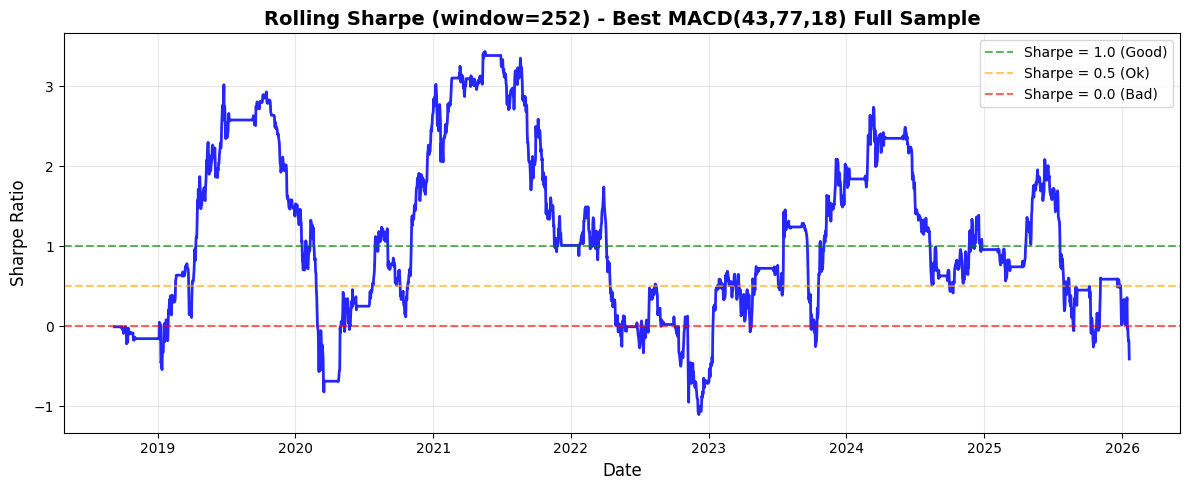

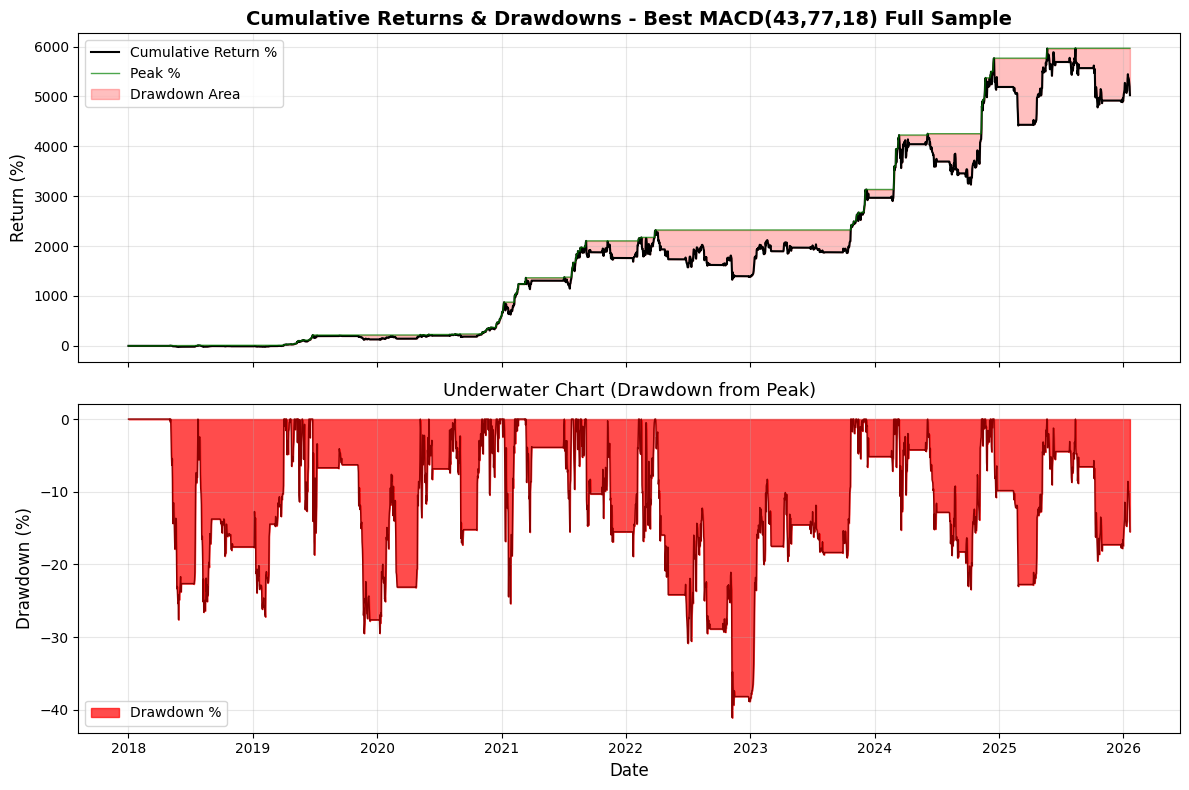

✅ Rolling Sharpe and Drawdown analysis complete for best strategy: MACD(43,77,18)


In [52]:
import vectorbt as vbt
import numpy as np
import matplotlib.pyplot as plt

# --- FULL-SAMPLE ROLLING SHARPE + DRAWDOWNS - BEST MACD STRATEGY ---

# Ensure Frequency is set
if 'FREQ' not in globals():
    FREQ = "1D"

if results_df.empty:
    print("No results to visualize.")
else:
    # 1. GET THE BEST STRATEGY PARAMETERS
    # Retrieve the row with the highest Sharpe Ratio
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]
    
    # Extract the winning MACD periods (convert to integers)
    fast_window = int(best_result['Fast_Period'])
    slow_window = int(best_result['Slow_Period'])
    signal_window = int(best_result['Signal_Period'])

    # 2. BUILD INDICATORS ON FULL DATASET
    # We use 'close' (the entire dataset), not just 'train_close' or 'val_close'.
    macd_full = vbt.MACD.run(
        close, 
        fast_window=fast_window, 
        slow_window=slow_window, 
        signal_window=signal_window
    )

    # 3. GENERATE MACD CROSSOVER SIGNALS
    # Buy: MACD Line crosses ABOVE Signal Line
    entries_full = macd_full.macd_crossed_above(macd_full.signal)
    
    # Sell: MACD Line crosses BELOW Signal Line
    exits_full = macd_full.macd_crossed_below(macd_full.signal)

    # Prepare price data as a standard numpy array
    price_full = close.to_numpy(dtype=float)

    # 4. RUN THE FULL PORTFOLIO SIMULATION
    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,      # 0.05% Fees
        slippage=0.0005,  # 0.05% Slippage
        freq=FREQ         # Ensure this matches your data frequency (e.g., '1D')
    )

    # 5. COMPUTE RETURNS
    # We extract the daily returns to plot the rolling metrics later.
    ret = pf_full.returns()
    
    print(f"Full-Sample Portfolio Ready. Best MACD({fast_window}, {slow_window}, {signal_window})")

    # --- VISUALIZATION: ROLLING SHARPE & DRAWDOWNS ---

    # 1) ROLLING SHARPE RATIO (252-day window)
    # This checks if the strategy performance degrades over time.

    # Define window size (approx 1 trading year = 252 days)
    rolling_window = max(20, min(252, max(1, len(ret) // 4)))

    # Check if we have enough data to calculate it
    if len(ret) > rolling_window:
        # Calculate Rolling Sharpe
        # Formula: (Mean Return * 252) / (Std Dev * sqrt(252))
        rolling_sharpe = ret.rolling(window=rolling_window).apply(
            lambda x: (x.mean() * 252) / (x.std() * np.sqrt(252)) if x.std() != 0 else np.nan,
            raw=False
        )

        # Plot the Rolling Sharpe
        plt.figure(figsize=(12, 5))
        plt.plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2, color='blue', alpha=0.85)
        
        # Add reference lines (Green=Good, Red=Bad)
        plt.axhline(y=1.0, color='green', linestyle='--', alpha=0.6, label='Sharpe = 1.0 (Good)')
        plt.axhline(y=0.5, color='orange', linestyle='--', alpha=0.6, label='Sharpe = 0.5 (Ok)')
        plt.axhline(y=0.0, color='red', linestyle='--', alpha=0.6, label='Sharpe = 0.0 (Bad)')
        
        plt.title(f'Rolling Sharpe (window={rolling_window}) - Best MACD({fast_window},{slow_window},{signal_window}) Full Sample', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Sharpe Ratio', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        print("⚠️ Not enough data for rolling Sharpe calculation.")

    # 2) DRAWDOWNS (UNDERWATER CHART)
    # This visualizes the "Pain" of holding the strategy.

    # Calculate Cumulative Wealth Curve
    eq = (1 + ret).cumprod()
    # Calculate the "All-Time High" at every point
    peak = eq.cummax()
    # Calculate Drawdown %: (Current Value - Peak) / Peak
    dd = (eq - peak) / peak

    # Create a chart with 2 panels (Returns on top, Drawdown on bottom)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # --- TOP PANEL: Cumulative Return ---
    ax1.plot(eq.index, (eq - 1) * 100, color='black', linewidth=1.5, label='Cumulative Return %')
    ax1.plot(peak.index, (peak - 1) * 100, color='green', linewidth=1.0, alpha=0.7, label='Peak %')

    # Fill the area between the Peak and Current Value to show "Lost Opportunity"
    ax1.fill_between(eq.index, (eq - 1) * 100, (peak - 1) * 100, color='red', alpha=0.25, label='Drawdown Area')

    ax1.set_title(f'Cumulative Returns & Drawdowns - Best MACD({fast_window},{slow_window},{signal_window}) Full Sample', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Return (%)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # --- BOTTOM PANEL: Underwater Plot ---
    # Fills the area from 0 down to the current drawdown level
    ax2.fill_between(dd.index, dd * 100, 0, color='red', alpha=0.7, label='Drawdown %')
    ax2.plot(dd.index, dd * 100, color='darkred', linewidth=1)

    ax2.set_title('Underwater Chart (Drawdown from Peak)', fontsize=13)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    print(f"✅ Rolling Sharpe and Drawdown analysis complete for best strategy: MACD({fast_window},{slow_window},{signal_window})")

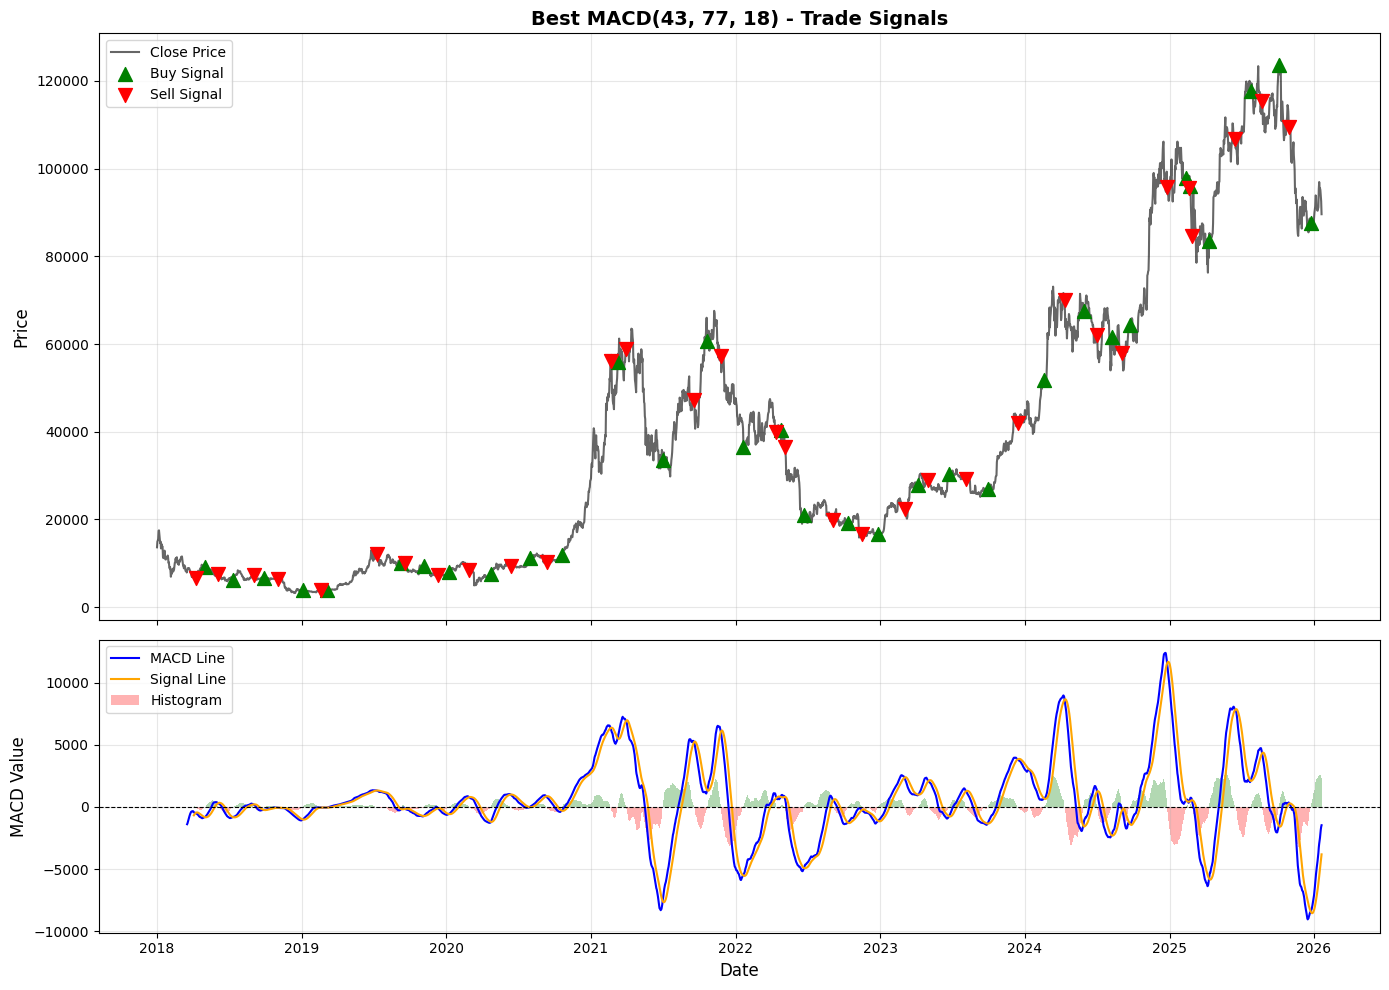

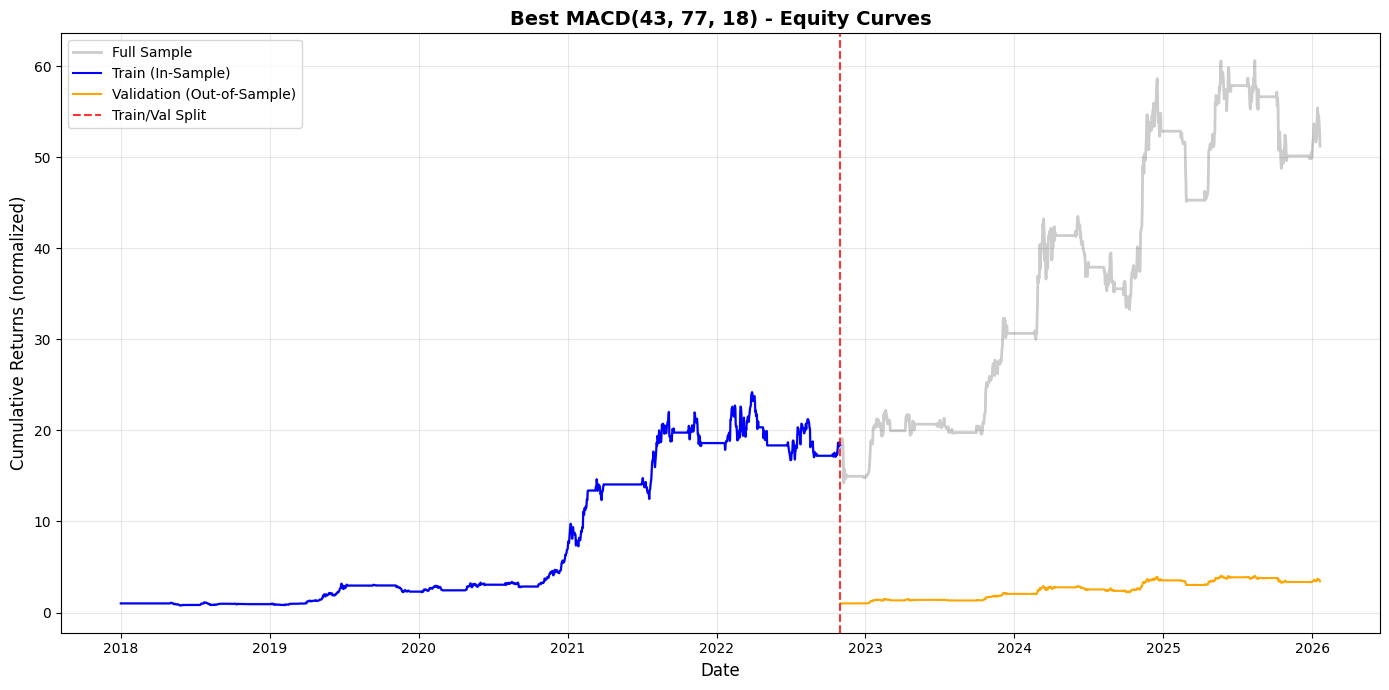

Visualizations complete for best strategy: MACD(43,77,18)


In [53]:
import vectorbt as vbt
import numpy as np
import matplotlib.pyplot as plt

# --- STEP 5C: VISUALS ONLY (Signals + Equity Curves) - BEST MACD STRATEGY ---

if results_df.empty:
    print("No results to visualize.")
else:
    # 1. GET BEST STRATEGY PARAMETERS
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]
    
    fast_window = int(best_result['Fast_Period'])
    slow_window = int(best_result['Slow_Period'])
    signal_window = int(best_result['Signal_Period'])

    # 2. BUILD INDICATORS (FULL SAMPLE)
    macd_ind = vbt.MACD.run(
        close, 
        fast_window=fast_window, 
        slow_window=slow_window, 
        signal_window=signal_window
    )

    # 3. GENERATE SIGNALS
    # Buy: MACD crosses ABOVE Signal
    entries_full = macd_ind.macd_crossed_above(macd_ind.signal)
    
    # Sell: MACD crosses BELOW Signal
    exits_full = macd_ind.macd_crossed_below(macd_ind.signal)

    # Clean up signals for plotting
    entries_full = entries_full.reindex(close.index).fillna(False).to_numpy(dtype=bool)
    exits_full = exits_full.reindex(close.index).fillna(False).to_numpy(dtype=bool)

    # --- PLOT 1: PRICE + TRADES (Top) & MACD INDICATOR (Bottom) ---
    
    # Create a figure with 2 subplots (Ratio 2:1)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    # --- TOP PANEL: PRICE & TRADES ---
    ax1.plot(close.index, close.values, label='Close Price', color='black', linewidth=1.5, alpha=0.6)
    
    # Plot Buy Arrows (Green Up)
    buy_idx = close.index[entries_full]
    ax1.scatter(buy_idx, close.reindex(buy_idx).values, marker='^', color='green', s=100, label='Buy Signal', zorder=5)

    # Plot Sell Arrows (Red Down)
    sell_idx = close.index[exits_full]
    ax1.scatter(sell_idx, close.reindex(sell_idx).values, marker='v', color='red', s=100, label='Sell Signal', zorder=5)
    
    ax1.set_title(f'Best MACD({fast_window}, {slow_window}, {signal_window}) - Trade Signals', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # --- BOTTOM PANEL: MACD LINES ---
    # Plot MACD Line
    ax2.plot(macd_ind.macd.index, macd_ind.macd.values, label='MACD Line', color='blue', linewidth=1.5)
    # Plot Signal Line
    ax2.plot(macd_ind.signal.index, macd_ind.signal.values, label='Signal Line', color='orange', linewidth=1.5)
    
    # Plot Histogram (Optional but helpful)
    hist = macd_ind.macd - macd_ind.signal
    # Color histogram green if positive, red if negative
    colors = np.where(hist >= 0, 'green', 'red')
    ax2.bar(hist.index, hist.values, color=colors, alpha=0.3, width=1.0, label='Histogram')

    ax2.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax2.set_ylabel('MACD Value', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- PREPARE DATA FOR EQUITY CURVES (Train vs Val) ---
    
    # Ensure split_idx exists
    if 'split_idx' not in globals():
        split_idx = int(len(close) * 0.8) # Default fallback

    price_full = close.to_numpy(dtype=float)
    
    # Slice arrays
    entries_train = entries_full[:split_idx]
    exits_train = exits_full[:split_idx]
    
    entries_val = entries_full[split_idx:]
    exits_val = exits_full[split_idx:]

    # Re-run Full Portfolio
    pf_full = vbt.Portfolio.from_signals(
        close=price_full,
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )
    
    # Training Portfolio (In-Sample)
    pf_train = vbt.Portfolio.from_signals(
        close=train_close.to_numpy(dtype=float),
        entries=entries_train,
        exits=exits_train,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    # Validation Portfolio (Out-of-Sample)
    pf_val2 = vbt.Portfolio.from_signals(
        close=val_close.to_numpy(dtype=float),
        entries=entries_val,
        exits=exits_val,
        init_cash=100_000,
        fees=0.0005,
        slippage=0.0005,
        freq=FREQ
    )

    # --- CALCULATE EQUITY CURVES ---
    eq_full = (1 + pf_full.returns()).cumprod()
    eq_train = (1 + pf_train.returns()).cumprod()
    eq_val = (1 + pf_val2.returns()).cumprod()

    # --- PLOT THE SPLIT ---
    fig, ax = plt.subplots(figsize=(14, 7))

    # 1. Plot Full History (Ghost)
    ax.plot(close.index, eq_full.values, label='Full Sample', color='black', linewidth=2, alpha=0.2)

    # 2. Plot Training Phase (Blue)
    ax.plot(train_close.index, eq_train.values, label='Train (In-Sample)', color='blue', linewidth=1.5)

    # 3. Plot Validation Phase (Orange)
    # Note: We align the start of the validation curve to the end of the training curve visually
    # or just plot them on their own timeline. Here we plot them on their actual dates.
    ax.plot(val_close.index, eq_val.values, label='Validation (Out-of-Sample)', color='orange', linewidth=1.5)

    # 4. Vertical Split Line
    ax.axvline(x=train_close.index[-1], color='red', linestyle='--', alpha=0.8, label='Train/Val Split')

    ax.set_title(f'Best MACD({fast_window}, {slow_window}, {signal_window}) - Equity Curves', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Cumulative Returns (normalized)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    print(f"Visualizations complete for best strategy: MACD({fast_window},{slow_window},{signal_window})")

Total trades plotted: 32
Win Rate: 53.1% (17W / 15L)
Avg Win: 52.55% | Avg Loss: -8.91%
Max Win: 370.02% | Max Loss: -22.79%


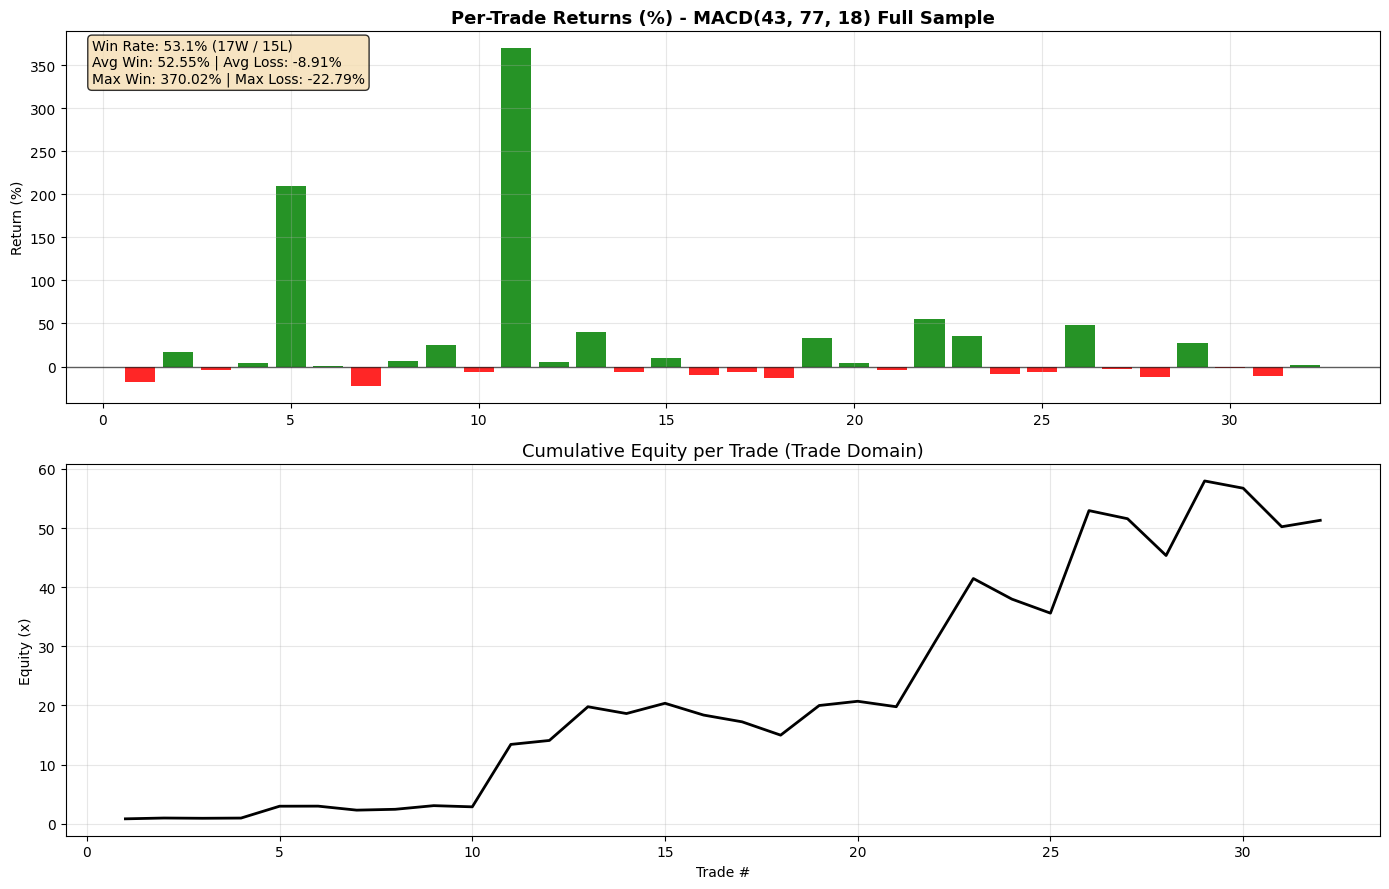

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vectorbt as vbt

# --- STEP 5D: FULL-SAMPLE TRADE-BY-TRADE RETURNS (BAR) + CUMULATIVE PER-TRADE EQUITY - MACD ---

# --- Default Configuration ---
if 'FREQ' not in globals():
    FREQ = "1D"

# --- Resolve Full Close Series ---
# Robust logic to find the 'Close' column regardless of data structure
if 'close' in globals() and hasattr(close, 'index'):
    full_close = close.astype(float)
else:
    # Fallback for complex DataFrames (e.g. from yfinance)
    if isinstance(stock_data.columns, pd.MultiIndex):
        if ('Close', TICKER) in stock_data.columns:
            full_close = stock_data[('Close', TICKER)].astype(float).rename(TICKER)
        else:
            # Search manually
            found = None
            for col in stock_data.columns:
                if isinstance(col, tuple) and ('Close' in col):
                    found = col
                    break
            if found is None:
                raise KeyError("Could not find a 'Close' column.")
            full_close = stock_data[found].astype(float).rename(TICKER)
    else:
        full_close = stock_data['Close'].astype(float).rename(TICKER)

# --- Best Parameters ---
if 'results_df' not in globals() or results_df.empty:
    print("results_df is empty. Please run the grid search first.")
else:
    # 1. RETRIEVE BEST STRATEGY PARAMETERS
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]

    # Extract MACD parameters
    fast_window = int(best_result['Fast_Period'])
    slow_window = int(best_result['Slow_Period'])
    signal_window = int(best_result['Signal_Period'])

    # --- Indicators ---
    # Run MACD on the FULL dataset
    macd_ind = vbt.MACD.run(
        full_close, 
        fast_window=fast_window, 
        slow_window=slow_window, 
        signal_window=signal_window
    )

    # --- Signals ---
    # Standard MACD Crossover Logic
    # Entry: MACD crosses ABOVE Signal
    entries_raw = macd_ind.macd_crossed_above(macd_ind.signal)
    
    # Exit: MACD crosses BELOW Signal
    exits_raw = macd_ind.macd_crossed_below(macd_ind.signal)

    # Convert to plain Series for safety
    entries_full = pd.Series(np.asarray(entries_raw).ravel(), index=full_close.index, dtype=bool)
    exits_full = pd.Series(np.asarray(exits_raw).ravel(), index=full_close.index, dtype=bool)

    # --- Backtest ---
    # Run Portfolio simulation on Full Sample
    pf_full = vbt.Portfolio.from_signals(
        close=full_close.to_numpy(dtype=float),
        entries=entries_full,
        exits=exits_full,
        init_cash=100_000,
        fees=0.0005,      # 0.05% Fees
        slippage=0.0005,  # 0.05% Slippage
        freq=FREQ
    )

    # --- Trade-by-Trade Returns Analysis ---
    trades = pf_full.trades
    
    # Robustly extract return values
    trade_returns = trades.returns.values if hasattr(trades.returns, 'values') else np.asarray(trades.returns)
    trade_returns = np.asarray(trade_returns).ravel()

    # Safety Check: Ensure trades exist
    if trade_returns.size == 0:
        print("No trades to plot.")
    else:
        # --- Calculate Statistics ---
        winning_trades = trade_returns[trade_returns > 0]
        losing_trades = trade_returns[trade_returns < 0]

        total_trades = len(trade_returns)
        win_count = len(winning_trades)
        loss_count = len(losing_trades)
        
        # Avoid division by zero
        win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0

        # Calculate Percentages (multiply by 100 for display)
        avg_win_pct = (winning_trades.mean() * 100) if len(winning_trades) > 0 else 0
        avg_loss_pct = (losing_trades.mean() * 100) if len(losing_trades) > 0 else 0
        max_win_pct = (winning_trades.max() * 100) if len(winning_trades) > 0 else 0
        max_loss_pct = (losing_trades.min() * 100) if len(losing_trades) > 0 else 0

        # Print stats to console
        print(f"Total trades plotted: {total_trades}")
        print(f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)")
        print(f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%")
        print(f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%")

        # --- Prepare Equity Curve (Trade Domain) ---
        equity_per_trade = np.cumprod(1.0 + trade_returns)

        # --- Plotting ---
        fig, axes = plt.subplots(2, 1, figsize=(14, 9), sharex=False)

        # Plot 1: Per-Trade Returns (Bar Chart)
        x = np.arange(1, trade_returns.size + 1)
        colors = np.where(trade_returns >= 0, 'green', 'red')
        
        axes[0].bar(x, trade_returns * 100.0, color=colors, alpha=0.85, width=0.8)
        axes[0].axhline(0, color='black', linewidth=1, alpha=0.6)

        # Create Stats Text Box
        stats_text = (
            f"Win Rate: {win_rate:.1f}% ({win_count}W / {loss_count}L)\n"
            f"Avg Win: {avg_win_pct:.2f}% | Avg Loss: {avg_loss_pct:.2f}%\n"
            f"Max Win: {max_win_pct:.2f}% | Max Loss: {max_loss_pct:.2f}%"
        )

        axes[0].text(0.02, 0.98, stats_text, transform=axes[0].transAxes,
                     fontsize=10, verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        # Formatting Plot 1
        axes[0].set_title(f"Per-Trade Returns (%) - MACD({fast_window}, {slow_window}, {signal_window}) Full Sample",
                          fontsize=13, fontweight='bold')
        axes[0].set_ylabel('Return (%)')
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Cumulative Equity per Trade
        axes[1].plot(x, equity_per_trade, color='black', linewidth=2)
        
        # Formatting Plot 2
        axes[1].set_title("Cumulative Equity per Trade (Trade Domain)", fontsize=13)
        axes[1].set_xlabel("Trade #")
        axes[1].set_ylabel("Equity (x)")
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [55]:
import vectorbt as vbt
import numpy as np
import pandas as pd

# --- SENSITIVITY ANALYSIS: CHECK SURROUNDING MACD PARAMETERS ---

# --- Safety Check ---
if results_df.empty:
    print("No results available for sensitivity analysis.")
else:
    # --- 1. Identify the Baseline (Best Strategy) ---
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]
    
    # Extract the winning parameters
    best_fast = int(best_result['Fast_Period'])
    best_slow = int(best_result['Slow_Period'])
    best_signal = int(best_result['Signal_Period'])

    print(f"Parameter Sensitivity Analysis for Best MACD({best_fast}, {best_slow}, {best_signal})")
    print("=" * 80)

    # --- 2. Define Test Ranges ---
    # We test +/- 15 around each parameter to check stability.
    # We use max() to prevent invalid (negative/zero) periods.
    fast_candidates = list(range(max(2, best_fast - 15), best_fast + 16))
    slow_candidates = list(range(max(3, best_slow - 15), best_slow + 16))
    signal_candidates = list(range(max(2, best_signal - 15), best_signal + 16))

    # --- 3. Generate Combinations (One-Variable-at-a-Time) ---
    # To keep it fast, we vary one parameter while locking the other two.
    combos = (
        [(f, best_slow, best_signal) for f in fast_candidates] +           # Vary Fast
        [(best_fast, s, best_signal) for s in slow_candidates if s != best_slow] + # Vary Slow
        [(best_fast, best_slow, sig) for sig in signal_candidates if sig != best_signal] # Vary Signal
    )

    # --- 4. Prepare Data for Speed ---
    # We use the training set for sensitivity to check if the fit was too tight
    price_np = train_close.to_numpy(dtype=float)
    
    # --- 5. Evaluation Function ---
    def eval_macd_combo(fast: int, slow: int, signal: int) -> dict:
        # Constraint Check: Fast must be < Slow for standard MACD logic
        if fast >= slow:
            return None 

        # Run MACD Indicator
        # We run it directly on the pandas Series 'train_close' (vbt handles this well)
        macd_ind = vbt.MACD.run(
            train_close, 
            fast_window=fast, 
            slow_window=slow, 
            signal_window=signal
        )

        # --- Define Logic ---
        # Entry: MACD crosses ABOVE Signal
        entries = macd_ind.macd_crossed_above(macd_ind.signal)
        
        # Exit: MACD crosses BELOW Signal
        exits = macd_ind.macd_crossed_below(macd_ind.signal)
        
        # --- Run Backtest ---
        pf = vbt.Portfolio.from_signals(
            close=train_close,    # Using pandas series preserves index alignment automatically
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.0005,
            slippage=0.0005,
            freq=FREQ
        )

        # --- Extract Key Metrics ---
        total_return = pf.total_return()
        sharpe = pf.sharpe_ratio(freq=FREQ)
        sortino = pf.sortino_ratio(freq=FREQ)
        mdd = pf.max_drawdown()
        vol = pf.annualized_volatility(freq=FREQ)

        # --- Trade Statistics ---
        trades = pf.trades
        ntr = len(trades)
        
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0

        if ntr > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                
                win_rate_pct = (len(pos) / len(tr)) * 100
                
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                profit_factor = gains / losses if losses > 0 else np.inf
                
                expectancy = tr.mean()

        return {
            'Fast': fast, 'Slow': slow, 'Signal': signal,
            'Sharpe': sharpe, 'Sortino': sortino,
            'Return': total_return, 'Max_DD': mdd, 'Vol': vol,
            'Trades': ntr, 'Win_Rate': win_rate_pct,
            'Profit_Factor': profit_factor, 'Expectancy': expectancy
        }

    # --- 6. Execute Simulations ---
    rows = []
    print(f"Testing {len(combos)} variations...")
    
    for combo in combos:
        try:
            res = eval_macd_combo(*combo)
            if res is not None:
                rows.append(res)
        except Exception as e:
            pass # Skip invalid combos

    # --- 7. Process & Display Results ---
    if not rows:
        print("No valid sensitivity results computed.")
    else:
        sens = pd.DataFrame(rows)

        # Define column order
        cols = ['Fast', 'Slow', 'Signal', 'Sharpe', 'Sortino', 'Return', 'Max_DD', 'Vol',
                'Trades', 'Win_Rate', 'Profit_Factor', 'Expectancy']
        
        sens_table = sens[cols].sort_values(['Fast', 'Slow', 'Signal'])

        print(f"\nSensitivity Results ({len(sens_table)} variations valid):\n")
        
        # Display first 10 and last 5 rows to save screen space (or use simple print for all)
        pd.set_option('display.max_rows', 20) 
        display(sens_table)

        # --- Compact Summary ---
        print("\n" + "="*50)
        print("SENSITIVITY SUMMARY (Robustness Check)")
        print("="*50)
        
        metric_cols = ['Sharpe', 'Sortino', 'Return', 'Max_DD', 'Vol', 'Win_Rate', 'Profit_Factor']
        summary = sens_table[metric_cols].agg(['mean', 'std', 'min', 'max']).T
        
        print(summary.round(4).to_string())
        
        # --- Interpretation ---
        sharpe_std = summary.loc['Sharpe', 'std']
        sharpe_mean = summary.loc['Sharpe', 'mean']
        cv = sharpe_std / abs(sharpe_mean) if sharpe_mean != 0 else 1.0
        
        print("\nInterpretation:")
        if cv < 0.2:
            print("✅ STRATEGY IS ROBUST: Low variance in results across similar parameters.")
        elif cv < 0.5:
            print("⚠️ MODERATE SENSITIVITY: Strategy is somewhat sensitive to exact parameters.")
        else:
            print("❌ FRAGILE / OVERFITTED: High variance. Small changes cause massive performance drops.")

Parameter Sensitivity Analysis for Best MACD(43, 77, 18)
Testing 91 variations...

Sensitivity Results (91 variations valid):



,Fast,Slow,Signal,Sharpe,Sortino,Return,Max_DD,Vol,Trades,Win_Rate,Profit_Factor,Expectancy
0,28,77,18,0.729264,1.089735,2.148120,-0.552305,0.488611,23,56.521739,2.474321,0.085451
1,29,77,18,0.607047,0.895157,1.360410,-0.572637,0.491351,25,36.000000,2.182225,0.074041
2,30,77,18,0.780911,1.167303,2.574690,-0.560873,0.492340,23,39.130435,2.996227,0.120852
3,31,77,18,0.847892,1.276177,3.184190,-0.546622,0.491018,23,43.478261,3.324865,0.129906
4,32,77,18,0.916874,1.384199,3.924519,-0.556006,0.490630,21,38.095238,3.737420,0.160341
...,...,...,...,...,...,...,...,...,...,...,...,...
26,54,77,18,0.884460,1.347007,3.526123,-0.623092,0.485628,23,43.478261,3.454876,0.173192
27,55,77,18,0.775468,1.171619,2.513881,-0.634017,0.487692,25,44.000000,2.841609,0.129960
28,56,77,18,0.607097,0.902584,1.356874,-0.629438,0.485044,25,52.000000,2.454755,0.110486
29,57,77,18,0.664854,0.990558,1.697437,-0.618399,0.484535,26,57.692308,2.569113,0.109629



SENSITIVITY SUMMARY (Robustness Check)
                  mean     std      min      max
Sharpe          1.1834  0.2154   0.6070   1.5233
Sortino         1.8869  0.3838   0.8952   2.5140
Return          8.6605  3.9670   1.3569  17.4026
Max_DD         -0.4467  0.0872  -0.6340  -0.2950
Vol             0.4743  0.0078   0.4641   0.4923
Win_Rate       48.6691  5.7973  36.0000  62.5000
Profit_Factor   6.0421  1.9051   2.1822   9.4881

Interpretation:
✅ STRATEGY IS ROBUST: Low variance in results across similar parameters.


In [58]:
import vectorbt as vbt
import numpy as np
import pandas as pd

# --- OOS SENSITIVITY ANALYSIS (Validation on 'val_close') - MACD ---

# --- Safety Check ---
if results_df.empty:
    print("No results available.")
else:
    # --- 1. Identify the Baseline (Best Strategy from TRAINING) ---
    best_idx = results_df['Sharpe_Ratio'].idxmax()
    best_result = results_df.loc[best_idx]
    
    # Extract Best MACD Parameters
    best_fast = int(best_result['Fast_Period'])
    best_slow = int(best_result['Slow_Period'])
    best_signal = int(best_result['Signal_Period'])

    print(f"Validation Analysis for Best MACD({best_fast}, {best_slow}, {best_signal}) on 'val_close'")
    print("=" * 80)

    # --- 2. Define Test Ranges (Neighbors) ---
    # We create a range of +/- 15 around the winners
    fast_candidates = list(range(max(2, best_fast - 15), best_fast + 16))
    slow_candidates = list(range(max(3, best_slow - 15), best_slow + 16))
    signal_candidates = list(range(max(2, best_signal - 15), best_signal + 16))

    # --- 3. Generate Combinations (One-Variable-at-a-Time) ---
    combos = (
        [(f, best_slow, best_signal) for f in fast_candidates] +
        [(best_fast, s, best_signal) for s in slow_candidates if s != best_slow] +
        [(best_fast, best_slow, sig) for sig in signal_candidates if sig != best_signal]
    )

    # --- 4. Prepare Validation Data ---
    # Explicitly targeting the validation set
    target_data = val_close 

    # --- 5. Evaluation Function (Using Validation Data) ---
    def eval_macd_val(fast: int, slow: int, signal: int) -> dict:
        # Constraint: Fast < Slow
        if fast >= slow:
            return None

        # Calculate Indicators on val_close
        # Note: We run it directly on the pandas Series so indexes align automatically
        macd_ind = vbt.MACD.run(
            target_data, 
            fast_window=fast, 
            slow_window=slow, 
            signal_window=signal
        )

        # Logic: Standard MACD Crossover
        entries = macd_ind.macd_crossed_above(macd_ind.signal)
        exits = macd_ind.macd_crossed_below(macd_ind.signal)
        
        # Run Backtest on val_close
        pf = vbt.Portfolio.from_signals(
            close=target_data, 
            entries=entries, 
            exits=exits, 
            init_cash=100_000,
            fees=0.0005, 
            slippage=0.0005, 
            freq=FREQ
        )

        # Extract Metrics
        total_return = float(pf.total_return())
        sharpe = float(pf.sharpe_ratio(freq=FREQ))
        sortino = float(pf.sortino_ratio(freq=FREQ))
        mdd = float(pf.max_drawdown())
        vol = float(pf.annualized_volatility(freq=FREQ))

        trades = pf.trades
        ntr = len(trades)
        
        win_rate_pct = np.nan
        profit_factor = np.nan
        expectancy = 0.0

        if ntr > 0:
            tr = trades.returns.values if hasattr(trades.returns, 'values') else np.array(trades.returns)
            if tr.size > 0:
                pos = tr[tr > 0]
                neg = tr[tr < 0]
                win_rate_pct = (len(pos) / len(tr)) * 100
                gains = pos.sum() if len(pos) else 0.0
                losses = abs(neg.sum()) if len(neg) else 0.0
                profit_factor = gains / losses if losses > 0 else np.inf
                expectancy = float(tr.mean())

        return {
            'Fast': fast, 'Slow': slow, 'Signal': signal,
            'Sharpe': sharpe, 'Sortino': sortino,
            'Return': total_return, 'Max_DD': mdd, 'Vol': vol,
            'Trades': ntr, 'Win_Rate': win_rate_pct,
            'Profit_Factor': profit_factor, 'Expectancy': expectancy
        }

    # --- 6. Execute Simulations ---
    rows_val = []
    print(f"Running {len(combos)} Validation simulations...")
    
    for combo in combos:
        try:
            res = eval_macd_val(*combo)
            if res is not None:
                rows_val.append(res)
        except Exception:
            pass

    # --- 7. Process Results ---
    if not rows_val:
        print("No Validation results computed.")
    else:
        sens_val = pd.DataFrame(rows_val)

        cols = ['Fast', 'Slow', 'Signal', 'Sharpe', 'Sortino', 'Return', 'Max_DD', 'Vol',
                'Trades', 'Win_Rate', 'Profit_Factor', 'Expectancy']
        
        sens_table_val = sens_val[cols].sort_values(['Fast', 'Slow', 'Signal'])

        print(f"Validation Sensitivity Results (Top 20 rows shown):\n")
        
        # Display top 20 to keep output clean, or remove limit to see all
        pd.set_option('display.max_rows', None)
        display(sens_table_val)
        
        # --- Summary ---
        print("\n" + "="*60)
        print("VALIDATION SENSITIVITY SUMMARY (Robustness Check)")
        print("="*60)
        
        metric_cols = ['Sharpe', 'Sortino', 'Return', 'Max_DD', 'Vol', 'Win_Rate', 'Profit_Factor']
        summary_val = sens_table_val[metric_cols].agg(['mean', 'std', 'min', 'max']).T

        print(summary_val.round(4).to_string())

       

Validation Analysis for Best MACD(43, 77, 18) on 'val_close'
Running 91 Validation simulations...
Validation Sensitivity Results (Top 20 rows shown):



,Fast,Slow,Signal,Sharpe,Sortino,Return,Max_DD,Vol,Trades,Win_Rate,Profit_Factor,Expectancy
0,28,77,18,1.196793,1.984639,1.789016,-0.309283,0.303954,16,43.750000,5.183753,0.078943
1,29,77,18,1.037154,1.704757,1.372919,-0.309685,0.301761,17,47.058824,3.578006,0.064197
2,30,77,18,0.987863,1.623224,1.252667,-0.340874,0.299922,17,47.058824,3.284358,0.061176
3,31,77,18,1.137035,1.875465,1.625993,-0.346119,0.303329,16,37.500000,4.216226,0.076593
4,32,77,18,1.240795,2.063808,1.928093,-0.356723,0.305789,15,40.000000,4.940226,0.089803
5,33,77,18,1.179716,1.945181,1.768521,-0.337288,0.307275,15,40.000000,4.386641,0.089848
6,34,77,18,1.360010,2.275976,2.330313,-0.333927,0.309095,14,42.857143,4.857819,0.115056
7,35,77,18,1.311679,2.188299,2.182535,-0.314316,0.309943,14,57.142857,4.654325,0.109705
8,36,77,18,1.321128,2.206067,2.210595,-0.277323,0.309740,14,42.857143,4.625376,0.110780
9,37,77,18,1.127782,1.855977,1.623041,-0.300386,0.306325,14,42.857143,3.588379,0.093479



VALIDATION SENSITIVITY SUMMARY (Robustness Check)
                  mean     std      min      max
Sharpe          0.9869  0.2010   0.6073   1.3977
Sortino         1.5980  0.3609   0.9222   2.3706
Return          1.3203  0.4516   0.5735   2.3763
Max_DD         -0.2956  0.0608  -0.4133  -0.1885
Vol             0.3058  0.0082   0.2908   0.3262
Win_Rate       45.9664  5.5755  35.2941  61.5385
Profit_Factor   3.2351  0.8106   1.9468   5.2262
